# Total energy study
In this notebook, we calculate and compare total energy values given by each software power meter, BMC and external power meter.

## Import necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

from visualize import *
import seaborn as sns
import matplotlib.pyplot as plt

## Load experiment results

In [2]:
experiments_path = [
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-17_35_17',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-18_05_29',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-18_36_17',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-19_07_02',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-19_38_14',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-20_09_18',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-20_39_40',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-21_10_48',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-21_41_51',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-22_12_51'
]

experiments = []

for experiment_path in experiments_path:
    experiments.append(parse_experiment("../results/%s" % experiment_path))

# Additional processing is required for Scaphandre dataframes
# Scaphandre by component result dataframes will be joined into a single dataframe
process_scaphandre_dataframes(experiments)

# Loading GPU tools experiment results
gpu_tools_cpu_bench = pd.read_csv("../results/gpu-tools-cpu-benchs-results/CPU_benchmark.csv")

# Loading Perf tool experiment results
experiments_perf_path = [
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-18_30_29',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-18_40_04',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-18_49_39',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-18_59_26',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-19_09_05',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-19_18_50',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-19_28_33',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-19_38_20',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-19_48_05',
    'perf-evaluate-gemini-1.lyon.grid5000.fr-2023-02-07-19_57_44'
]

experiments_perf = []

for experiment_path in experiments_perf_path:
    experiments_perf.append(parse_experiment("../results/%s" % experiment_path))

## Total energy consumed by benchmarks
### Prepare CPU tools data for plotting

In [3]:
# Get consumption information by benchmark
benchmarks_powerapi = convert_exp_into_benchmark_dataframes(experiments, 'PowerAPI' ,'powerapi', 0)
benchmarks_scaphandre = convert_exp_into_benchmark_dataframes(experiments, 'Scaphandre' ,'scaphandre', 0)

# Construct result dataframe
result_df = pd.DataFrame(columns=['benchmark', 'tool', 'value'])

# Creating global dataframes for each benchmark and plotting them
for benchmark_index in range(len(benchmarks_powerapi)):

    # Getting info about benchmark from different solutions
    benchmark_name = list(benchmarks_powerapi)[benchmark_index]
    benchmark_powerapi = benchmarks_powerapi[benchmark_name]
    benchmark_scaphandre = benchmarks_scaphandre[benchmark_name]

    # Adding PowerApi results to result dataframe
    for result_index in range(len(benchmark_powerapi['powerapi'])):

        power_api_result = benchmark_powerapi['powerapi'][result_index]['dataframe']
        kwollect_result = benchmark_powerapi['kwollect'][result_index]['dataframe']

        # Calculate and get kwollect consumption
        wattmetre_consumption, bmc_consumption = kwollect_consumption(kwollect_result)

        # Adding consumption data to dataframe
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'powerapi',
            'source': 'wattmetre',
            'value': wattmetre_consumption
        })

        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'powerapi',
            'source': 'bmc',
            'value': bmc_consumption
        })

        # Calculate overall PowerAPI consumption
        power_api_result_sockets = power_api_result.groupby(['timestamp', 'target', 'scope'], as_index=False)['power'].sum()
        power_api_result_sockets['timestamp'] = power_api_result_sockets['timestamp'].dt.floor('1s')
        power_api_result_global_target = power_api_result_sockets.groupby(['timestamp', 'target'], as_index=False)['power'].sum()
        power_api_result_global_rapl = power_api_result_global_target[power_api_result_global_target['target'] == 'rapl']
        power_api_result_global_rapl = power_api_result_global_rapl.drop(columns=['target'])

        # Calculate overall consumption from dataframe
        overall_consumption_powerapi = overall_consumption_from_df(power_api_result_global_rapl, 'power')
        
        # Adding consumption data to dataframe
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'powerapi',
            'source': 'rapl',
            'value': overall_consumption_powerapi[0]
        })

        # Calculating and adding PowerAPI process consumption
        power_api_result_global_process = power_api_result_global_target[power_api_result_global_target['target'] == '/benchmark']
        power_api_result_global_process = power_api_result_global_process.drop(columns=['target'])

        overall_process_consumption_powerapi = overall_consumption_from_df(power_api_result_global_process, 'power')

        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'powerapi',
            'source': 'process',
            'value': overall_process_consumption_powerapi[0]
        })


        # Add offset between wattmetre and tool
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'powerapi',
            'source': 'offset',
            'value': wattmetre_consumption-overall_consumption_powerapi[0]
        })


    # Adding Scaphandre data to result dataframe
    for result_index in range(len(benchmark_scaphandre['scaphandre'])):

        scaphandre_result = benchmark_scaphandre['scaphandre'][result_index]['dataframe']
        kwollect_result = benchmark_scaphandre['kwollect'][result_index]['dataframe']

        # Calculate and get kwollect consumption
        wattmetre_consumption, bmc_consumption = kwollect_consumption(kwollect_result)

        # Adding consumption data to dataframe
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'scaphandre',
            'source': 'wattmetre',
            'value': wattmetre_consumption
        })

        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'scaphandre',
            'source': 'bmc',
            'value': bmc_consumption
        })

        # Calculate overall scaphandre consumption
        scaphandre_result['timestamp'] = scaphandre_result['timestamp'].dt.floor('5s')
        scaphandre_result_host_dram = scaphandre_result[(scaphandre_result['target'] == 'host') | (scaphandre_result['target'] == 'dram')]
        scaphandre_result_global = scaphandre_result_host_dram.groupby(['timestamp'], as_index=False)['value'].sum(min_count=2)
        # Delete all lines with NaN values
        scaphandre_result_global = scaphandre_result_global.dropna(subset=["value"])

        # Calculate overall consumption from dataframe
        overall_consumption_scaphandre = overall_consumption_from_df(scaphandre_result_global)

        # Adding consumption data to dataframe
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'scaphandre',
            'source': 'rapl',
            'value': overall_consumption_scaphandre[0]
        })

        # Adding Scaphandre process consumption
        scaphandre_result_process = scaphandre_result[(scaphandre_result['target'] != 'host') & (scaphandre_result['target'] != 'dram')]

        overall_process_consumption_scaphandre = overall_consumption_from_df(scaphandre_result_process)
        # Adding tool and wattmetre offset data to dataframe
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'scaphandre',
            'source': 'process',
            'value': overall_process_consumption_scaphandre[0]
        })

        # Add offset between wattmetre and tool
        result_df = add_consumption_value_to_df(result_df, {
            'benchmark': str(benchmark_name),
            'tool': 'scaphandre',
            'source': 'offset',
            'value': wattmetre_consumption-overall_consumption_scaphandre[0]
        })


result_df['value'] = result_df['value'] / 1000
result_df['source'] = result_df['source'].replace(['rapl'], ['tool'])
result_df['tool'] = result_df['tool'].replace(['powerapi','scaphandre'], ['PA','SC'])

result_df

,benchmark,tool,value,source
0,EP NAS Benchmark,PA,57.617172,wattmetre
1,EP NAS Benchmark,PA,48.330000,bmc
2,EP NAS Benchmark,PA,9.593705,tool
3,EP NAS Benchmark,PA,8.202223,process
4,EP NAS Benchmark,PA,48.023467,offset
...,...,...,...,...
295,MG NAS Benchmark,SC,158.725642,wattmetre
296,MG NAS Benchmark,SC,137.610000,bmc
297,MG NAS Benchmark,SC,28.024551,tool
298,MG NAS Benchmark,SC,20.485127,process


### Prepare Perf tool data for plotting

In [4]:
# Get consumption information by benchmark
benchmarks_perf = convert_exp_into_benchmark_dataframes(experiments_perf, 'Perf' ,'perf', 0)

# Construct result dataframe
result_df_perf = pd.DataFrame(columns=['benchmark', 'tool', 'value'])

# Creating global dataframes for each benchmark and plotting them
for benchmark_index in range(len(benchmarks_perf)):

    # Getting info about benchmark from different solutions
    benchmark_name = list(benchmarks_perf)[benchmark_index]
    benchmark_perf = benchmarks_perf[benchmark_name]

    # Adding Perf results to result dataframe
    for result_index in range(len(benchmark_perf['perf'])):

        perf_result = benchmark_perf['perf'][result_index]['dataframe']
        kwollect_result = benchmark_perf['kwollect'][result_index]['dataframe']

        # Calculate and get kwollect consumption
        wattmetre_consumption, bmc_consumption = kwollect_consumption(kwollect_result)

        # Adding consumption data to dataframe
        result_df_perf = add_consumption_value_to_df(result_df_perf, {
            'benchmark': str(benchmark_name),
            'tool': 'perf',
            'source': 'wattmetre',
            'value': wattmetre_consumption
        })

        result_df_perf = add_consumption_value_to_df(result_df_perf, {
            'benchmark': str(benchmark_name),
            'tool': 'perf',
            'source': 'bmc',
            'value': bmc_consumption
        })

        perf_result = perf_result.groupby(['benchmark','tool'], as_index=False)['value'].sum()

        result_df_perf = add_consumption_value_to_df(result_df_perf, {
            'benchmark': str(benchmark_name),
            'tool': 'perf',
            'source': 'rapl',
            'value': perf_result['value']
        })

result_df_perf['tool'] = 'PE'
result_df_perf.loc[result_df_perf['benchmark'] == 'EP D NAS Benchmark','benchmark'] = 'EP NAS Benchmark'
result_df_perf.loc[result_df_perf['benchmark'] == 'LU C NAS Benchmark','benchmark'] = 'LU NAS Benchmark'
result_df_perf.loc[result_df_perf['benchmark'] == 'MG D NAS Benchmark','benchmark'] = 'MG NAS Benchmark'
result_df_perf['source'] = result_df_perf['source'].replace(['rapl'], ['tool'])
result_df_perf['value'] = result_df_perf['value'] / 1000

result_df_perf

,benchmark,tool,value,source
0,EP NAS Benchmark,PE,57.752514,wattmetre
1,EP NAS Benchmark,PE,48.600000,bmc
2,EP NAS Benchmark,PE,9.588820,tool
3,EP NAS Benchmark,PE,57.916569,wattmetre
4,EP NAS Benchmark,PE,48.600000,bmc
...,...,...,...,...
85,MG NAS Benchmark,PE,138.060000,bmc
86,MG NAS Benchmark,PE,28.524440,tool
87,MG NAS Benchmark,PE,149.709308,wattmetre
88,MG NAS Benchmark,PE,127.800000,bmc


### Fusion Global data with Perf tool data

In [5]:
global_df = pd.concat([result_df, result_df_perf])
global_df

,benchmark,tool,value,source
0,EP NAS Benchmark,PA,57.617172,wattmetre
1,EP NAS Benchmark,PA,48.330000,bmc
2,EP NAS Benchmark,PA,9.593705,tool
3,EP NAS Benchmark,PA,8.202223,process
4,EP NAS Benchmark,PA,48.023467,offset
...,...,...,...,...
85,MG NAS Benchmark,PE,138.060000,bmc
86,MG NAS Benchmark,PE,28.524440,tool
87,MG NAS Benchmark,PE,149.709308,wattmetre
88,MG NAS Benchmark,PE,127.800000,bmc


### Prepare GPU tools data for plotting

In [6]:
gpu_tools_cpu_bench = gpu_tools_cpu_bench[gpu_tools_cpu_bench["Tool"] > 0]
gpu_tools_cpu_bench = pd.melt(gpu_tools_cpu_bench, id_vars=["tool_name", "gpu_0_appli", "gpu_0_appli_class"], value_vars=["External\npower meter", "BMC", "Tool", "Offset"])
gpu_tools_cpu_bench.rename(columns={'gpu_0_appli':'benchmark', 'tool_name': 'tool', 'variable':'source'}, inplace=True)
gpu_tools_cpu_bench = gpu_tools_cpu_bench.drop(['gpu_0_appli_class'], axis=1)
gpu_tools_cpu_bench['benchmark'] = gpu_tools_cpu_bench['benchmark'].replace(['ep', 'lu','mg'], ['EP NAS Benchmark','LU NAS Benchmark','MG NAS Benchmark'])
gpu_tools_cpu_bench['source'] = gpu_tools_cpu_bench['source'].replace(['Tool', 'External\npower meter', 'BMC', 'Offset'], ['tool', 'wattmetre', 'bmc', 'offset'])
gpu_tools_cpu_bench = gpu_tools_cpu_bench[gpu_tools_cpu_bench['benchmark'] != 'idle']
gpu_tools_cpu_bench = gpu_tools_cpu_bench[gpu_tools_cpu_bench['tool'] != 'ES']
gpu_tools_cpu_bench

,tool,benchmark,source,value
1,CT,MG NAS Benchmark,wattmetre,146.324327
2,CT,LU NAS Benchmark,wattmetre,33.508095
3,CT,EP NAS Benchmark,wattmetre,57.977553
5,CC,MG NAS Benchmark,wattmetre,138.047157
6,CC,LU NAS Benchmark,wattmetre,32.287249
...,...,...,...,...
619,GA,LU NAS Benchmark,offset,21.470400
620,GA,MG NAS Benchmark,offset,97.330800
621,MCI,EP NAS Benchmark,offset,44.514000
622,MCI,LU NAS Benchmark,offset,27.014400


In [7]:
global_df = pd.concat([global_df, gpu_tools_cpu_bench])
global_df = global_df[global_df['source'] != 'offset']
#global_df[(global_df['tool'] == 'PA') & (global_df['source'] == 'tool')]

### Plot total energy consumed by benchmarks

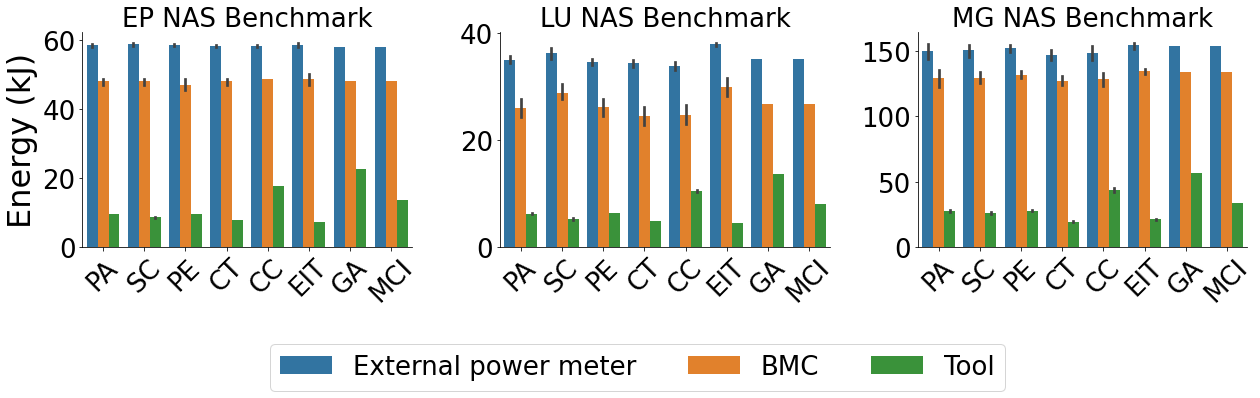

In [8]:
plt.rcParams.update({'font.size': 26})

ax = sns.catplot(x="tool", 
        y="value", 
        hue="source", 
        col="benchmark", 
        data=global_df[global_df['source']!='process'], 
        kind="bar", 
        sharey=False, 
        hue_order=['wattmetre', 'bmc', 'tool'],
        height=5, 
        aspect=1.2
)
ax.set_titles(template='{col_name}')
ax.set_xlabels("")
ax.set_ylabels("Energy (kJ)", fontsize="32")

# Change legend texts
ax.legend.set_title(None)
for t, l in zip(ax.legend.texts, ['External power meter', 'BMC', 'Tool']):
    t.set_text(l)

sns.move_legend(ax,
    "upper left",
    bbox_to_anchor=(0.19, 0.02),
    ncol=4,
    frameon=True
)

ax.set_xticklabels(rotation=45)

ax.savefig('../figures/alltools_barplot_with_gpu_and_perf_no_energy_scope.pdf')
ax.savefig('../figures/alltools_barplot_with_gpu_and_perf_no_energy_scope.png')